## Principal Component Analysis

As suggested by the reviewer 1, the authors should perform a dimensionality reduction using the calculated descriptors (The Ro5 and Veber's rules) so one can view the outliers such as everolimus, etc, in a 2D or 3D plot (or both).

In [1]:
# Importing the libraries
from rdkit import Chem, rdBase
from rdkit.Chem import Draw, Descriptors, PandasTools, AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.SaltRemover import SaltRemover, InputFormat

import matplotlib
from matplotlib.patches import Rectangle
from matplotlib.text import OffsetFrom
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn.datasets import load_wine

import session_info

In [2]:
# Loading the dataset
drugs_db_route_merged = pd.read_csv("../data/correlation_dataset.csv")

In [3]:
# Dropping unwanted columns
drugs_db_route_merged = drugs_db_route_merged.drop(drugs_db_route_merged.columns[drugs_db_route_merged.columns.str.contains("Unnamed")], axis=1)

drugs_db_route_merged = drugs_db_route_merged.drop(columns=['follow_tpsa', 'follow_h_sum', 'countplot'], axis=1)

# Keeping only relevant columns
drugs = drugs_db_route_merged[['active', 'route', 'mw', 'n_hba', 'n_hbd', 'logp', 'tpsa', 'rb', 'h_sum', 'follow_mw', 'follow_n_hba', 'follow_n_hbd', 'follow_logp', 'follow_rb', 'follow_tpsa_or_h_sum']]
drugs

,active,route,mw,n_hba,n_hbd,logp,tpsa,rb,h_sum,follow_mw,follow_n_hba,follow_n_hbd,follow_logp,follow_rb,follow_tpsa_or_h_sum
0,troglitazone,oral,441.160994,6,2,4.37426,84.86,5,8,1,1,1,1,1,1
1,imiquimod,topical,240.137497,4,1,2.82270,56.73,2,5,1,1,1,1,1,1
2,anagrelide,oral,254.996617,3,1,1.92630,44.70,0,4,1,1,1,1,1,1
3,nelfinavir,oral,567.313078,6,4,4.74762,101.90,9,10,0,1,1,1,1,1
4,delavirdine,oral,456.194360,6,3,2.71710,110.43,6,9,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558,omidenepag,ophthalmic,520.189274,9,1,3.41690,119.31,11,10,0,1,1,1,0,1
559,futibatinib,oral,418.175339,8,1,1.78490,108.39,4,9,1,1,1,1,1,1
560,olutasidenib,oral,354.088353,5,2,2.92498,90.68,3,7,1,1,1,1,1,1
561,adagrasib,oral,603.252479,8,0,4.73298,88.83,7,8,0,1,1,1,1,1


In [4]:
# Creating number of followed rules by each molecule
drugs['count_lipinski'] = drugs.follow_mw + drugs.follow_n_hba + drugs.follow_n_hbd + drugs.follow_logp
# True for non compliant drugs
drugs['non_compliant'] = drugs['count_lipinski'] == 0

# Creating true for oral drugs
drugs['oral'] = drugs['route'].str.contains('oral')
drugs

/tmp/ipykernel_18820/1452904298.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drugs['count_lipinski'] = drugs.follow_mw + drugs.follow_n_hba + drugs.follow_n_hbd + drugs.follow_logp
/tmp/ipykernel_18820/1452904298.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drugs['non_compliant'] = drugs['count_lipinski'] == 0
/tmp/ipykernel_18820/1452904298.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


,active,route,mw,n_hba,n_hbd,logp,tpsa,rb,h_sum,follow_mw,follow_n_hba,follow_n_hbd,follow_logp,follow_rb,follow_tpsa_or_h_sum,count_lipinski,non_compliant,oral
0,troglitazone,oral,441.160994,6,2,4.37426,84.86,5,8,1,1,1,1,1,1,4,False,True
1,imiquimod,topical,240.137497,4,1,2.82270,56.73,2,5,1,1,1,1,1,1,4,False,False
2,anagrelide,oral,254.996617,3,1,1.92630,44.70,0,4,1,1,1,1,1,1,4,False,True
3,nelfinavir,oral,567.313078,6,4,4.74762,101.90,9,10,0,1,1,1,1,1,3,False,True
4,delavirdine,oral,456.194360,6,3,2.71710,110.43,6,9,1,1,1,1,1,1,4,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558,omidenepag,ophthalmic,520.189274,9,1,3.41690,119.31,11,10,0,1,1,1,0,1,3,False,False
559,futibatinib,oral,418.175339,8,1,1.78490,108.39,4,9,1,1,1,1,1,1,4,False,True
560,olutasidenib,oral,354.088353,5,2,2.92498,90.68,3,7,1,1,1,1,1,1,4,False,True
561,adagrasib,oral,603.252479,8,0,4.73298,88.83,7,8,0,1,1,1,1,1,3,False,True


### Labels

In [5]:
X = drugs[['mw', 'n_hba', 'n_hbd', 'logp']]
target_rules = drugs.non_compliant
target_oral = drugs.oral

In [29]:
# Getting rid of the NaN
drugs.loc[drugs.oral.isnull(), 'oral'] = False

In [30]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_scaled

array([[-0.14555438, -0.16025194, -0.21392113,  0.51725794],
       [-0.70796754, -0.4994318 , -0.40539584,  0.01707732],
       [-0.66639546, -0.66902173, -0.40539584, -0.27189759],
       ...,
       [-0.38916172, -0.32984187, -0.21392113,  0.0500496 ],
       [ 0.3079368 ,  0.17892792, -0.59687055,  0.63289948],
       [ 1.32601235,  0.51810778, -0.21392113,  1.57739352]])

In [31]:
pca = PCA(n_components=4)
pca.fit(X_scaled)
pca_drugs = pca.transform(X_scaled)

In [32]:
PC1 = pca_drugs[:,0]
PC2 = pca_drugs[:,1]

label_rules = ['compliant', 'non compliant']
label_oral = ['non oral','oral']

legend_rules = [label_rules[point] for point in target_rules]
legend_oral = [label_oral[point] for point in target_oral]

In [37]:
zipped = list(zip(PC1, PC2, target_rules, target_oral, legend_rules, legend_oral ))
pca_df = pd.DataFrame(zipped, columns=['pc1', 'pc2', 'rules', 'oral', 'legend_rules', 'legend_oral'])

<Figure size 640x480 with 0 Axes>

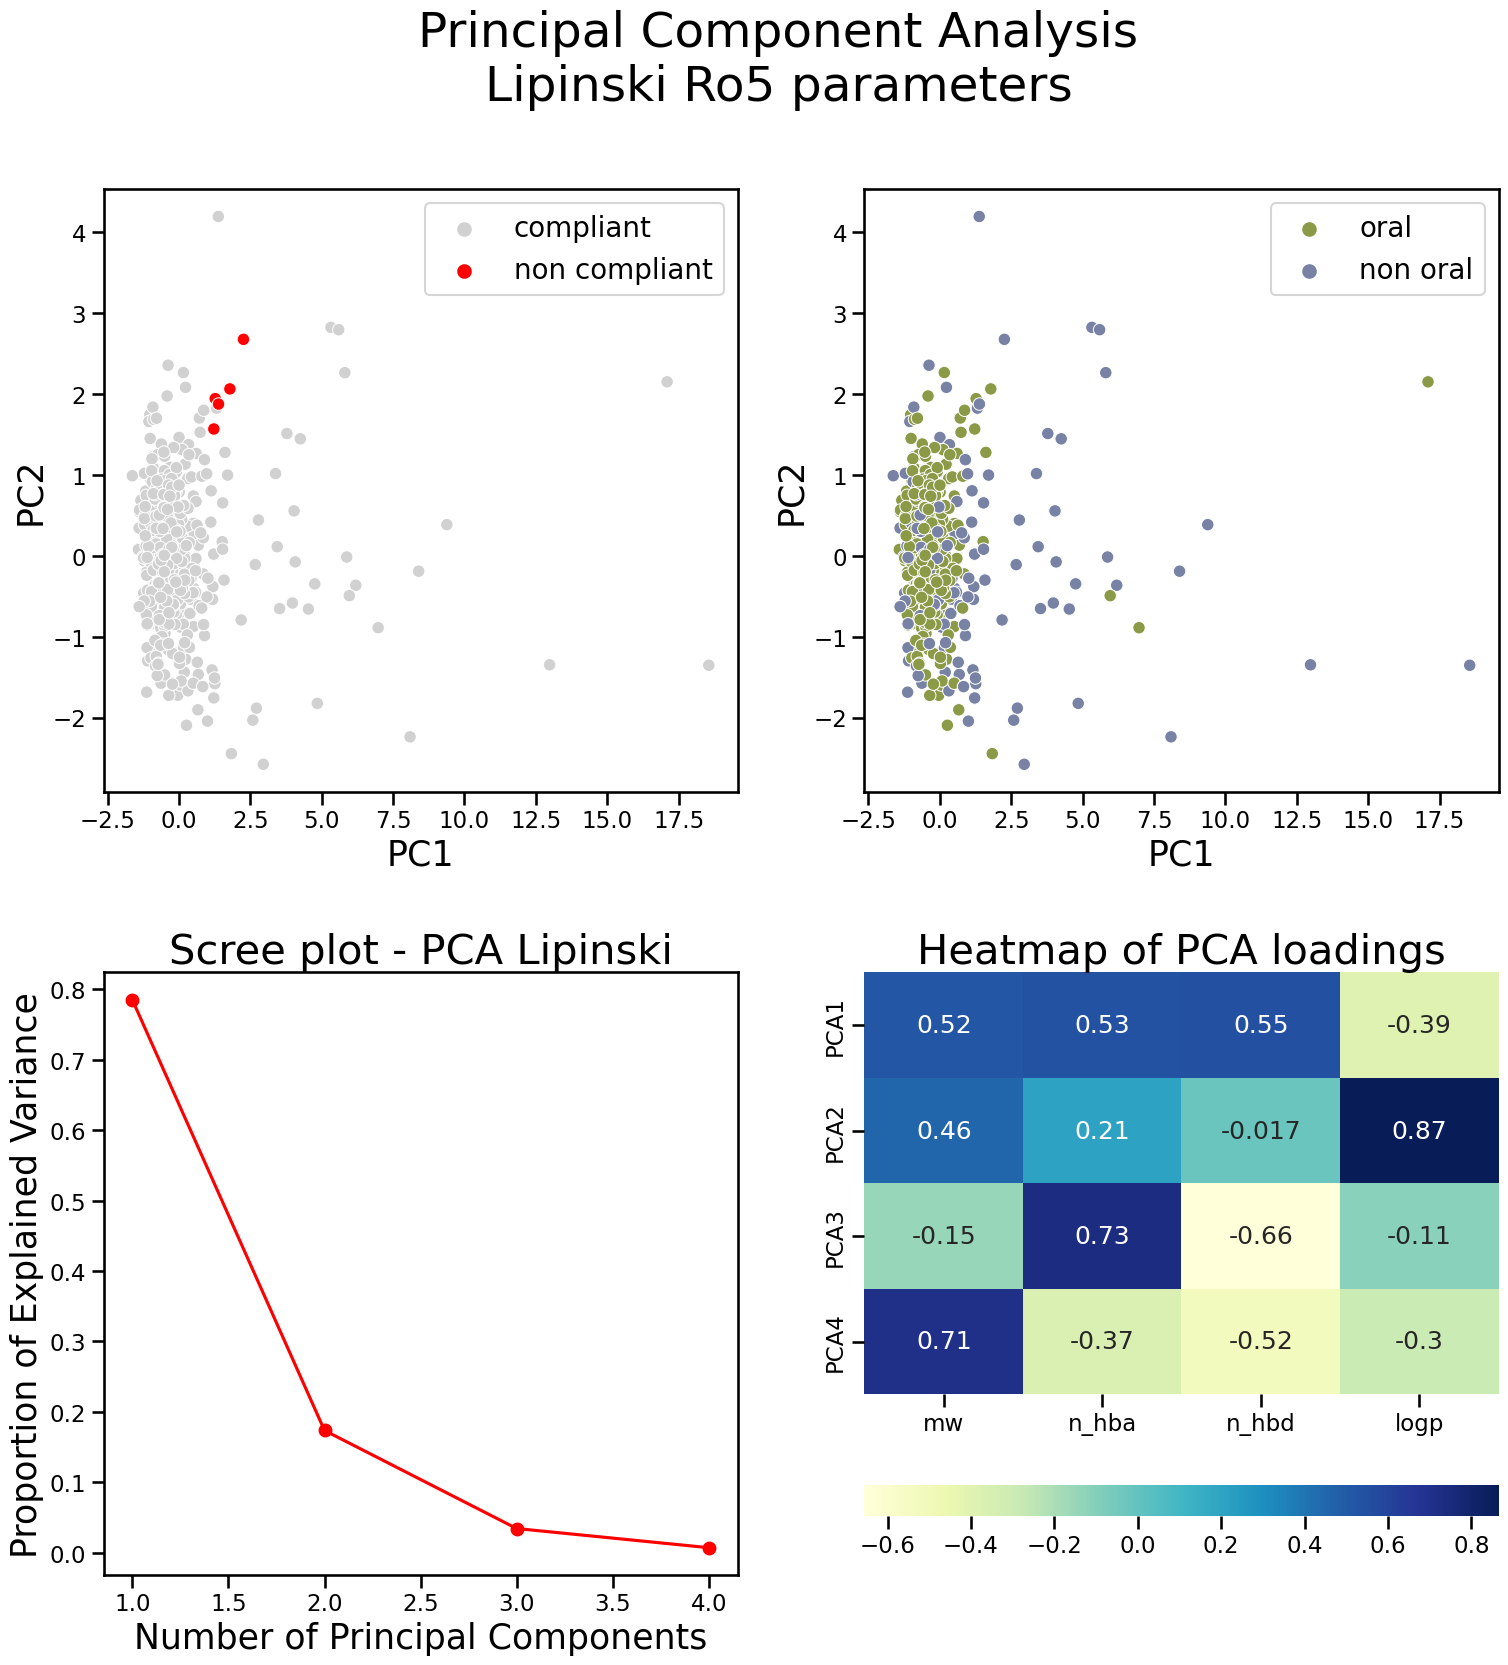

In [134]:
sns.set_context('talk')
plt.tight_layout()
fig, axs = plt.subplots(2,2, figsize = (18,18))


sns.scatterplot(data= pca_df,
                x="pc1",
                y="pc2",
                hue="legend_rules", 
                ax=axs[0][0], palette={'compliant':'#D1D1D1', 'non compliant':'red'})
axs[0][0].legend(title='',fontsize=20)
axs[0][0].set_ylabel('PC2',fontsize=25)
axs[0][0].set_xlabel('PC1',fontsize=25)

sns.scatterplot(data= pca_df,
                x="pc1",
                y="pc2",
                hue="legend_oral",
                ax=axs[0][1], palette={'oral':'#8B9A46', 'non oral':'#7882A4'})
axs[0][1].legend(title='', fontsize=20)
axs[0][1].set_ylabel('PC2',fontsize=25)
axs[0][1].set_xlabel('PC1',fontsize=25)

PC_values = np.arange(pca.n_components_) + 1
axs[1][0].plot(PC_values, pca.explained_variance_ratio_, 'ro-')
axs[1][0].set_title('Scree plot - PCA Lipinski', fontsize=30)
axs[1][0].set_xlabel('Number of Principal Components', fontsize=25)
axs[1][0].set_ylabel('Proportion of Explained Variance',fontsize=25)

sns.heatmap(pca.components_,
                 cmap='YlGnBu',
                 yticklabels=[ "PCA"+str(x) for x in range(1,pca.n_components_+1)],
                 xticklabels=list(X.columns),
                 cbar_kws={"orientation": "horizontal"},
                 annot=True)
axs[1][1].set_title('Heatmap of PCA loadings', fontsize=30)


fig.suptitle('Principal Component Analysis\nLipinski Ro5 parameters', fontsize=35)
plt.subplots_adjust(hspace=0.3)

We could include RB and TPSA into the parameters of the PCA

## Veber

In [58]:
X_veber = drugs[['rb', 'tpsa', 'h_sum', 'oral']]

In [59]:
import plotly.express as px
fig = px.scatter_3d(X_veber, x='rb', y='tpsa', z='h_sum',
              color='oral')
fig.show()